In [1]:
!pip install --upgrade pip
!pip install --upgrade pyarrow requests
!pip install -q datasets transformers sentence_transformers faiss-gpu bitsandbytes accelerate tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 r

In [2]:
from datasets import load_dataset , Dataset , DatasetDict , concatenate_datasets
from transformers import AutoTokenizer
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
from sentence_transformers import SentenceTransformer


In [3]:
import os
from google.colab import userdata
os.environ['HF_TOKEN'] = userdata.get('hf_token')

In [4]:
ar_dataset = load_dataset("akbargherbal/six_millions_instruction_dataset_for_arabic_llm_ft", split='train[:100000]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6372734 [00:00<?, ? examples/s]

In [5]:
ar_dataset

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 100000
})

In [6]:
en_dataset = load_dataset("garage-bAInd/Open-Platypus")

Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

In [7]:
en_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [8]:
en_dataset = en_dataset.remove_columns(['data_source'])
en_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 24926
    })
})

In [9]:
en_dataset = en_dataset['train']

In [10]:
#make prompt templete for our data
def prompt_templeta(example):
  example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n" if not example['input'] else \
  f"### Instruction:\n{example['instruction']}\n\n### Input:\n{example['input']}\n\n### Response:\n"
  return example

In [11]:
ar_dataset= ar_dataset.map(prompt_templeta,remove_columns = ['input'])

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [12]:
ar_dataset

Dataset({
    features: ['output', 'instruction'],
    num_rows: 100000
})

In [13]:
ar_dataset['instruction'][0]

'### Instruction:\nتوليد نسخة أكثر تعقيدا من هذه الجملة حصلت على دبلوم الدراسات العليا في الإذاعة الصحفية من جامعة لندن.\n\n### Response:\n'

In [14]:
ar_dataset['output'][0]

'بالطبع، نسخة أكثر تعقيداً من الجملة هي "لقد حصلت على دبلوم الدراسات العليا في الصحافة الإذاعية من جامعة سيتي في لندن قبل السفر إلى كندا للعمل كمقدمة على خدمات الإذاعة والتلفزيون التابعة لشركة الإذاعة الكندية".'

In [15]:
en_dataset = en_dataset.map(prompt_templeta,remove_columns = ['input'])

Map:   0%|          | 0/24926 [00:00<?, ? examples/s]

In [16]:
en_dataset

Dataset({
    features: ['output', 'instruction'],
    num_rows: 24926
})

In [17]:
#check distributions of tokens
model_checkpoint = "tiiuae/falcon-7b"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [18]:
def plot_distribution(dataset , title):
  instruction_token_counts = [len(tokenizer.tokenize(example)) for example in dataset['instruction']]
  output_token_counts = [len(tokenizer.tokenize(example)) for example in dataset['output']]
  combined_token_counts = [i+o for i , o in zip(instruction_token_counts , output_token_counts)]

  sns.set_style("whitegrid")
  fig , axes = plt.subplots(3 , 1 , figsize = (15 , 20))

  axes[0].hist(instruction_token_counts ,bins=50, color='#3498db', edgecolor='black' )
  axes[0].set_title(f"instructon token count for {title} dataset")
  axes[0].set_xlabel("Tokens number")
  axes[0].set_ylabel("token frequency")

  axes[1].hist(output_token_counts ,bins=50, color='#3498db', edgecolor='black' )
  axes[1].set_title(f"output tokens count for {title} dataset")
  axes[1].set_xlabel("Token number")
  axes[1].set_ylabel("token frequency")

  axes[2].hist(combined_token_counts ,bins=50, color='#3498db', edgecolor='black' )
  axes[2].set_title(f"combined  tokens count for {title} dataset")
  axes[2].set_xlabel("Token number")
  axes[2].set_ylabel("tokens frequency")

  plt.tight_layout()
  plt.show()


Token indices sequence length is longer than the specified maximum sequence length for this model (2772 > 2048). Running this sequence through the model will result in indexing errors


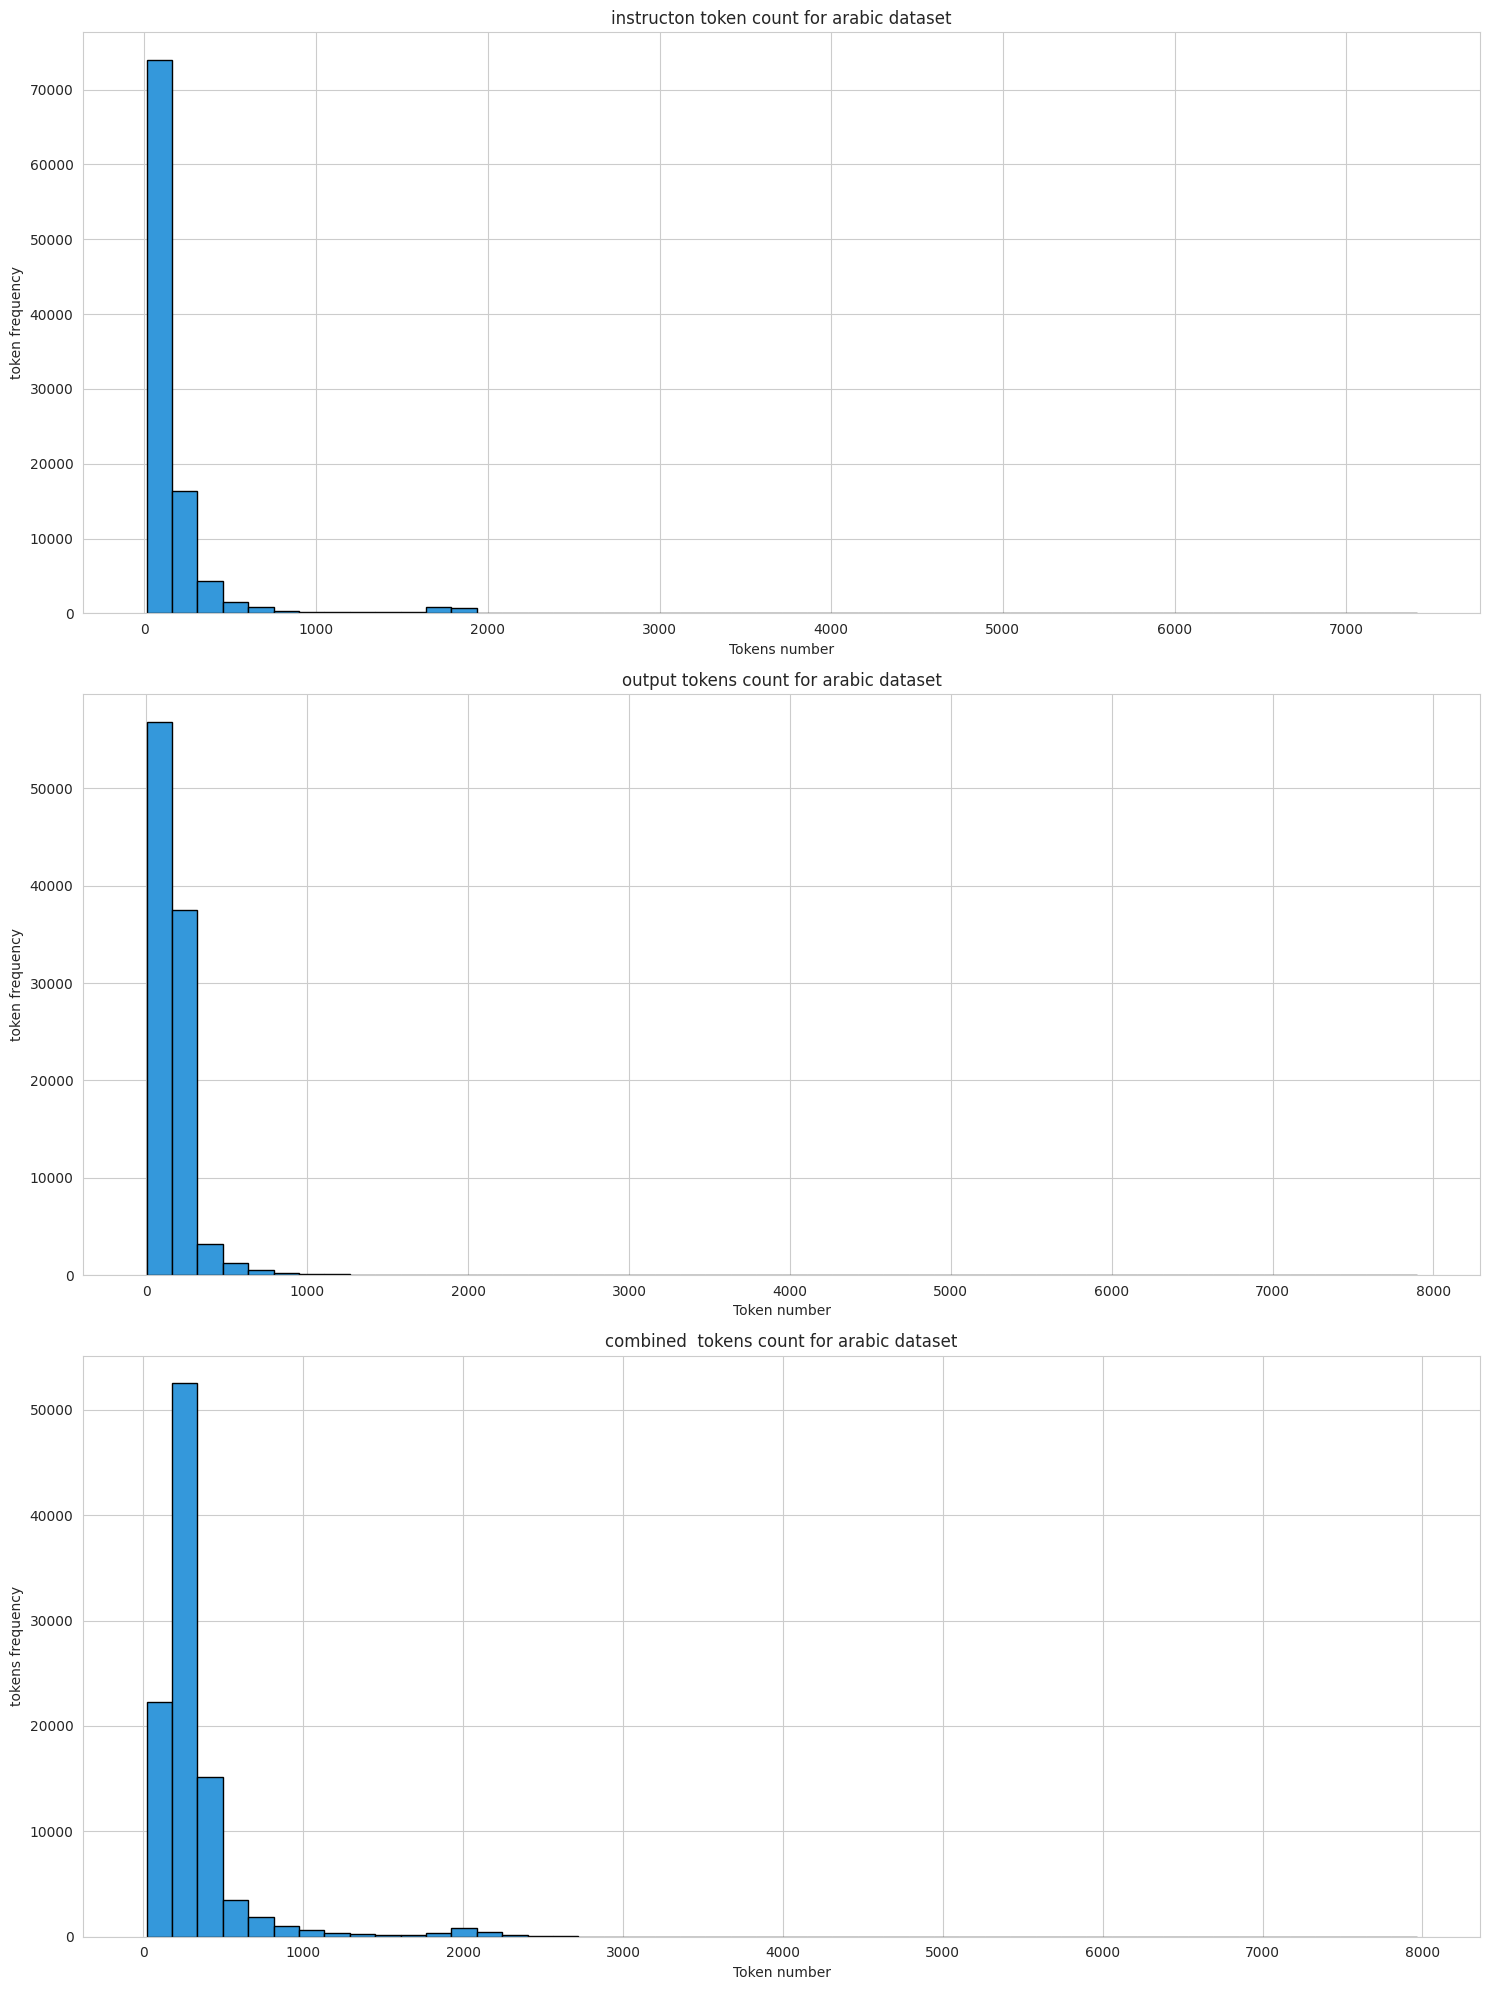

In [19]:
plot_distribution(ar_dataset , 'arabic')

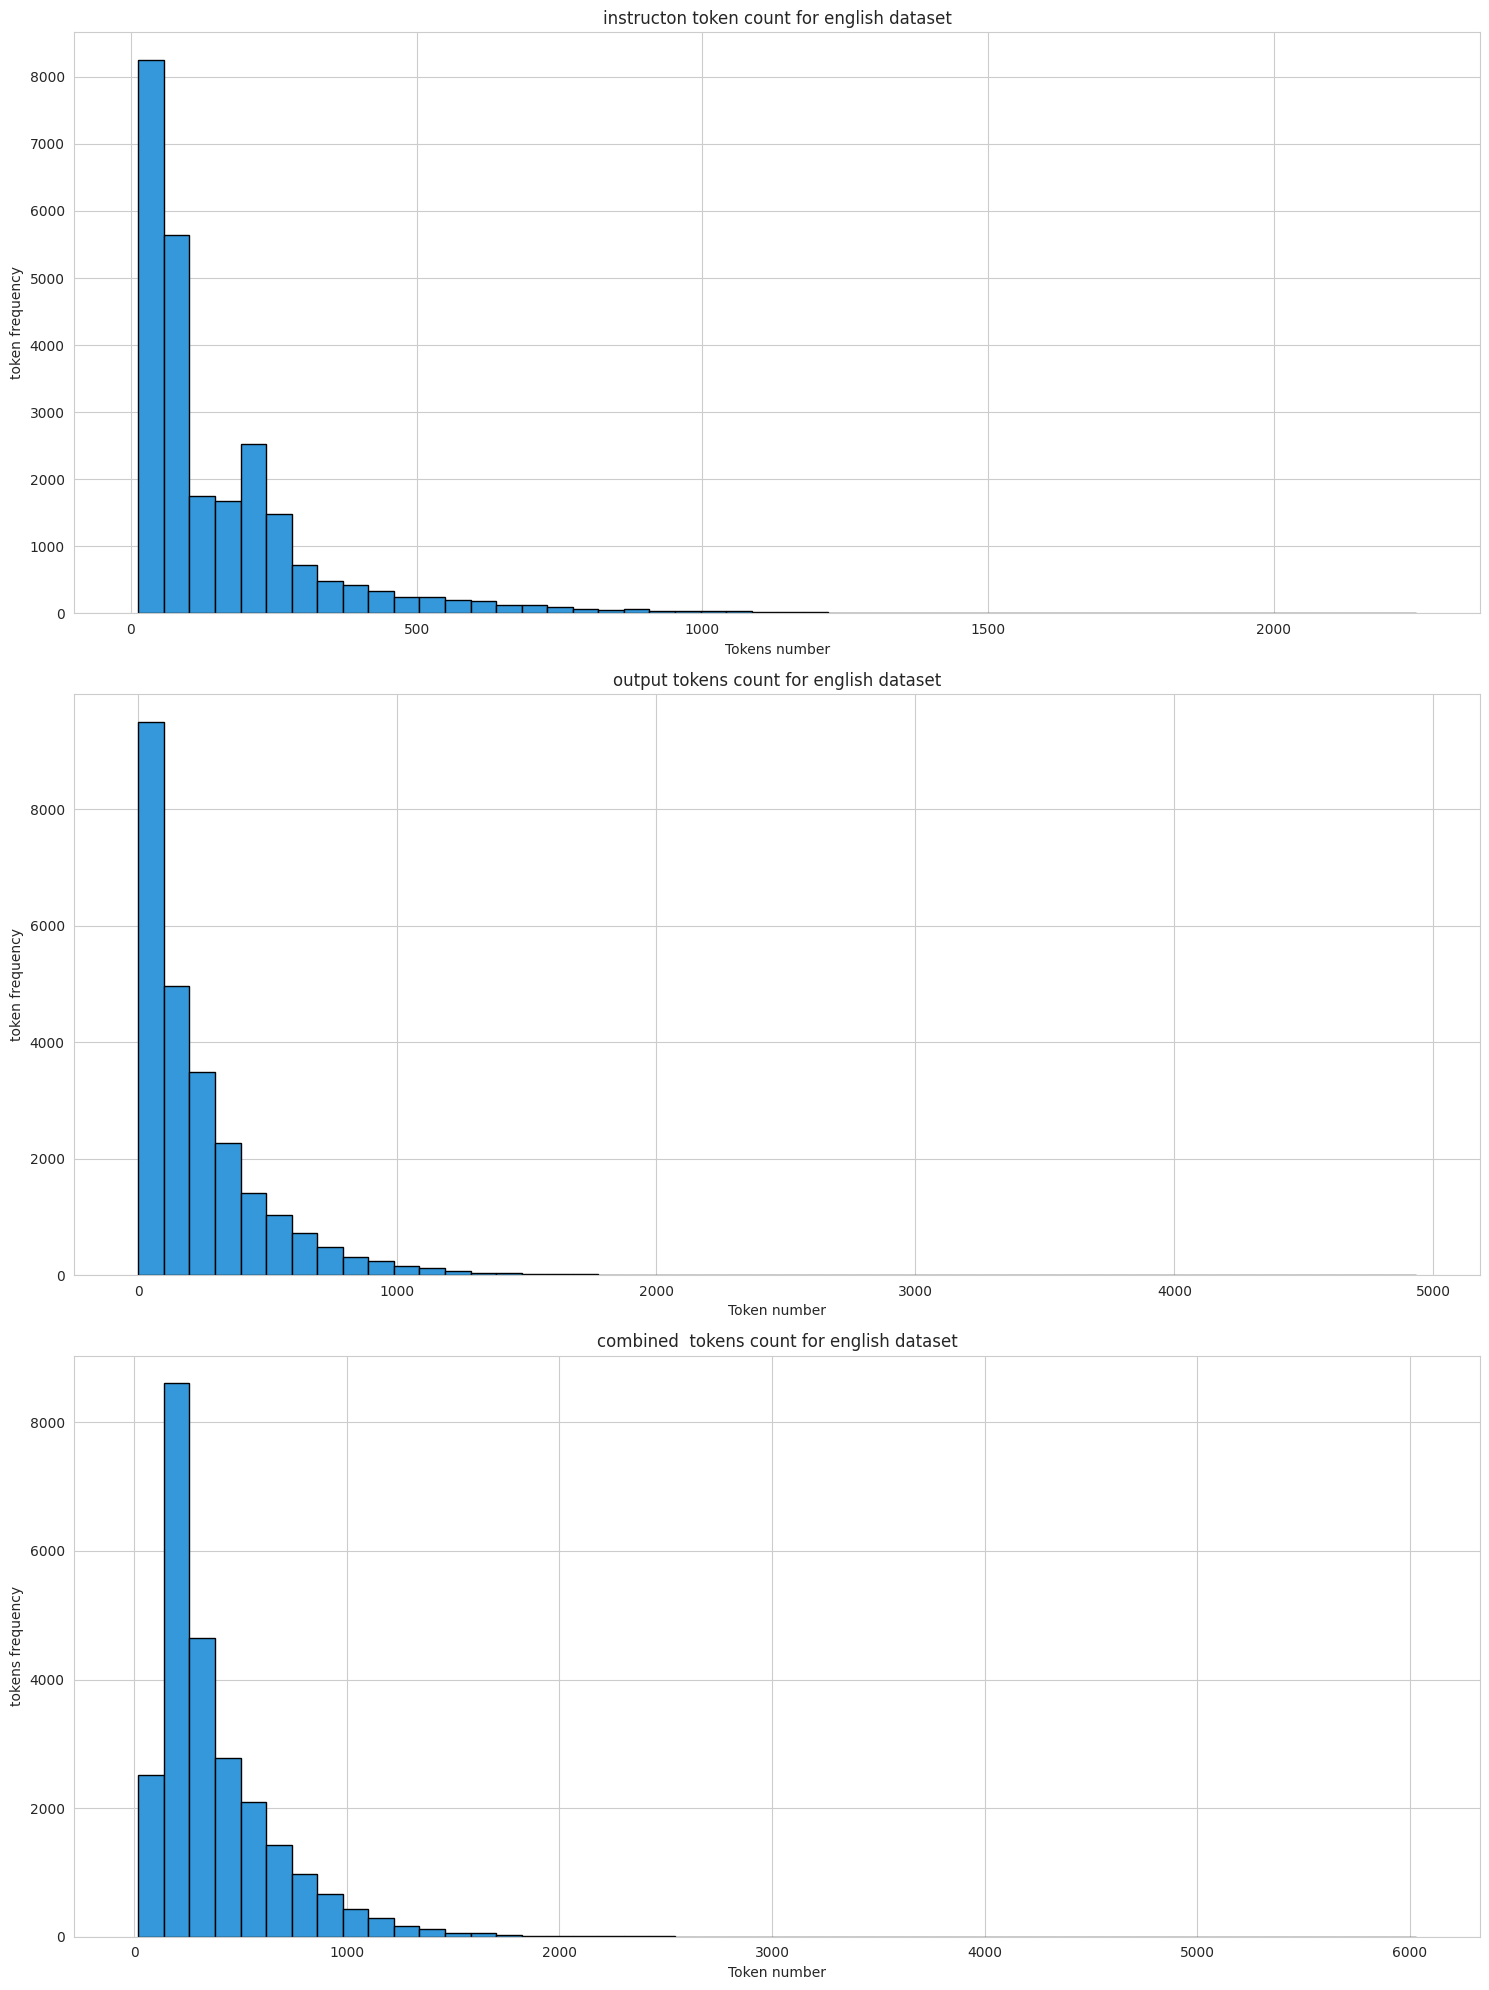

In [20]:
plot_distribution(en_dataset , 'english')

In [21]:
max_length = 1100
def get_indices(dataset):

  token_counts = [len(tokenizer.tokenize(example['instruction']+example['output'])) for example in dataset]

  token_indices = [i for i , k in enumerate(token_counts) if k <=max_length]
  return token_indices


In [22]:
ar_indices = get_indices(ar_dataset)
print("number of selected arabic items , " , len(ar_indices))
en_indices = get_indices(en_dataset)
print("number of selected english items , " , len(en_indices))


number of selected arabic items ,  96929
number of selected english items ,  24136


In [23]:
ar_dataset = ar_dataset.select(ar_indices)
en_dataset = en_dataset.select(en_indices)

In [24]:
ar_dataset

Dataset({
    features: ['output', 'instruction'],
    num_rows: 96929
})

In [25]:
#filter dublicated data that have the same meaning so we will use embeddins
embedding_model_checkpoint = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(embedding_model_checkpoint)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [26]:
from tqdm import tqdm
def filter_dublicates(dataset, threshold=0.95):

  #we remove dublicated by drop data that have the same output meaning

  outputs = [example['output'] for example in dataset]

  print("Embedding texts to vector in progress ....")

  embeddings = model.encode(outputs , show_progress_bar = True)

  dimension = embeddings.shape[1]

  #make index to search

  index = faiss.IndexFlatIP(dimension)

  #normalize index to speed searching
  normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
  index.add(normalized_embeddings)

  print("filtering dublicated data in progress ....")

  D, I = index.search(normalized_embeddings, k=2)
  to_keep = []

  for i in tqdm(range(len(embeddings)), desc="Filtering"):
      # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
      if D[i, 1] >= threshold:
          # Check if either the current item or its nearest neighbor is already in the to_keep list
          nearest_neighbor = I[i, 1]

          if i not in to_keep and nearest_neighbor not in to_keep:
              # If not, add the current item to the list
              to_keep.append(i)
      else:
          # If the similarity is below the threshold, always keep the current item
          to_keep.append(i)

  return dataset.select(to_keep)



In [31]:
ar_dataset = filter_dublicates(ar_dataset)

Embedding texts to vector in progress ....


Batches:   0%|          | 0/3030 [00:00<?, ?it/s]

filtering dublicated data in progress ....


Filtering: 100%|██████████| 96929/96929 [00:54<00:00, 1768.86it/s]


In [32]:
ar_dataset

Dataset({
    features: ['output', 'instruction'],
    num_rows: 81565
})

In [33]:
en_dataset = filter_dublicates(en_dataset)

Embedding texts to vector in progress ....


Batches:   0%|          | 0/755 [00:00<?, ?it/s]

filtering dublicated data in progress ....


Filtering: 100%|██████████| 24136/24136 [00:03<00:00, 7081.96it/s]  


In [34]:
en_dataset

Dataset({
    features: ['output', 'instruction'],
    num_rows: 19900
})

In [35]:
#we can filter data more to keep only instruction with more context it will be suitable for trainig ,
#have more instruction lead to good answer and model
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, k):
    # Sort by descending token count and get top k indices
    token_counts = [len(tokenizer.tokenize(example['instruction']+example['output'])) for example in dataset]
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    return dataset.select(top_k_indices)

In [38]:
k = 1500
ar_dataset = get_top_k_rows(ar_dataset ,k )

In [39]:
ar_dataset

Dataset({
    features: ['output', 'instruction'],
    num_rows: 1500
})

In [40]:
en_dataset = get_top_k_rows(en_dataset ,k )

In [41]:
en_dataset

Dataset({
    features: ['output', 'instruction'],
    num_rows: 1500
})

In [43]:
ar_dataset.push_to_hub("arabic-instruction-fine-tuning-prep", split='train')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Mohamed-Sami/arabic-instruction-fine-tuning-prep/commit/cecec586c64378e3535044003a91eca85b0d3fa4', commit_message='Upload dataset', commit_description='', oid='cecec586c64378e3535044003a91eca85b0d3fa4', pr_url=None, pr_revision=None, pr_num=None)

In [44]:
en_dataset.push_to_hub("english-instruction-fine-tuning-prep", split='train')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Mohamed-Sami/english-instruction-fine-tuning-prep/commit/5d0003c315831d86457d910849e371110953b9ce', commit_message='Upload dataset', commit_description='', oid='5d0003c315831d86457d910849e371110953b9ce', pr_url=None, pr_revision=None, pr_num=None)